In [14]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [17]:
w, h = 640, 640
border = 5 

In [18]:
ids = next(os.walk("dataset_copy_3_imgs/train/Images"))[2] # list of names all images in the given path
print(ids)
print("No. of images = ", len(ids))

['2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', '4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', '8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']
No. of images =  3


# **Data Reading and Train test split**

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
import glob
train = sorted(glob.glob("dataset_copy_3_imgs/train/Images/*"))
train_mask = sorted(glob.glob("dataset_copy_3_imgs/train/Mask/*.jpg"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 3
Total Mask Image : 3


In [21]:
X = np.zeros((len(train), h, w, 1), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [22]:
for n, (img, mimg) in (enumerate(zip(train, train_mask))):
  print(n, img, mimg)

  # Load images
  img = load_img(img, color_mode = "grayscale")
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 1), mode = 'constant', preserve_range = True)

  # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  
  # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0 dataset_copy_3_imgs/train/Images\2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg dataset_copy_3_imgs/train/Mask\2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg
1 dataset_copy_3_imgs/train/Images\4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg dataset_copy_3_imgs/train/Mask\4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg
2 dataset_copy_3_imgs/train/Images\8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg dataset_copy_3_imgs/train/Mask\8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg


In [23]:
# Save the files in Numpy array for reusability
np.save('x_y_npy/x.npy', X)
np.save('x_y_npy/y.npy', y)
print(X.shape, y.shape)
X = np.load('x_y_npy/x.npy')
y = np.load('x_y_npy/y.npy')
print(X.shape, y.shape)

(3, 640, 640, 1) (3, 640, 640, 1)
(3, 640, 640, 1) (3, 640, 640, 1)


In [24]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect() #  用於清理不再使用的對象，釋放內存。

(2, 640, 640, 1) (2, 640, 640, 1) (1, 640, 640, 1) (1, 640, 640, 1)


526

# **Visualization the image and It masks**

1. X_train[idx, ..., 0] = X_train[idx, :, :, 0]

2. 現在讓我們解釋一下 squeeze() 的作用。在 NumPy 中，squeeze() 函數用於刪除大小為 1 的維度。在這種情況下，y_train[ix] 的形狀可能是 (640, 640, 1)，其中最後一個維度是 1。squeeze() 的作用是將這個大小為 1 的維度擠壓掉，使得遮罩的形狀變為 (640, 640)，這是 contour 函數期望的形狀。https://steam.oxxostudio.tw/category/python/example/matplotlib-contour.html
3. 它指定輪廓線應該在哪些值處繪製。如果省略此參數，contour 函數將自動選擇一組適合的值。

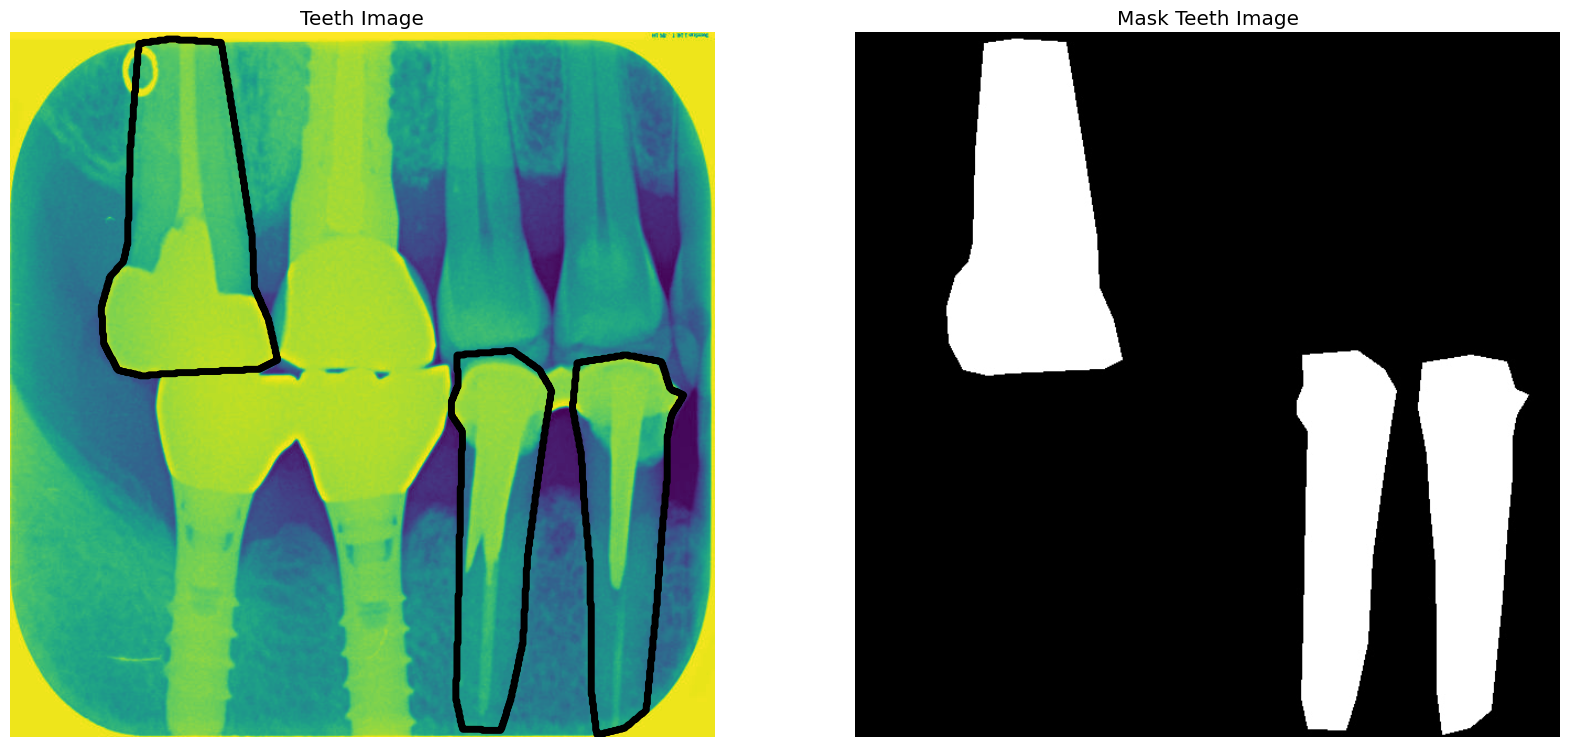

In [26]:
# Visualize any randome image along with the mask
idx = random.randint(0, len(X_train))
has_mask = y_train[idx].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[idx, ..., 0], interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Teeth Image')
ax1.set_axis_off() # 不顯示 x, y 軸線

ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Teeth Image')
ax2.set_axis_off() # 不顯示 x, y 軸線

In [27]:
dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def UnetPP(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

1. `清理 Keras Session` : 這一部分的目的是清理先前 Keras 會話中的任何模型，變數或計算圖。這有助於釋放資源並確保你在定義新模型之前的狀態是乾淨的。
2. `建立 U-Net++ 模型` : input_shape 參數指定了模型的輸入形狀，n_labels 指定了輸出的標籤數量，這裡是 1，可能是二元分類的情況。
3. `3. 定義評估指標（Metrics）`: 定義了一組評估指標（metrics）包括準確度（accuracy）、AUC、在特定特異度（Specificity）下的敏感度（Sensitivity）和在特定敏感度下的特異度。這些指標將在模型訓練過程中被計算。
4. `編譯模型` : 指定優化器（optimizer）為 Adam，損失函數（loss function）為二元交叉熵（binary_crossentropy），並指定了之前定義的評估指標列表。
5. `清理資源` : 最後一行使用 gc.collect() 進行垃圾回收，釋放不再使用的資源。

In [28]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 1), name='img')
# del model
model = UnetPP(input_shape = (640, 640, 1), n_labels=1) # change 
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

415

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 32)         320       ['input_image[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 640, 640, 32)         2560      ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 640, 640, 32)         0         ['batch_normalization[0][0

* tf.keras.utils.plot_model 函數繪製模型結構。該函數的參數說明如下：
1. `model`: 要繪製的 Keras 模型。
2. `to_file`: 指定保存圖像的文件名。
3. `show_shapes`: 如果為 True，將顯示每個層的輸入/輸出形狀。
4. `show_layer_names`: 如果為 True，將顯示每個層的名稱。
* https://blog.csdn.net/L_cherry_/article/details/122111303

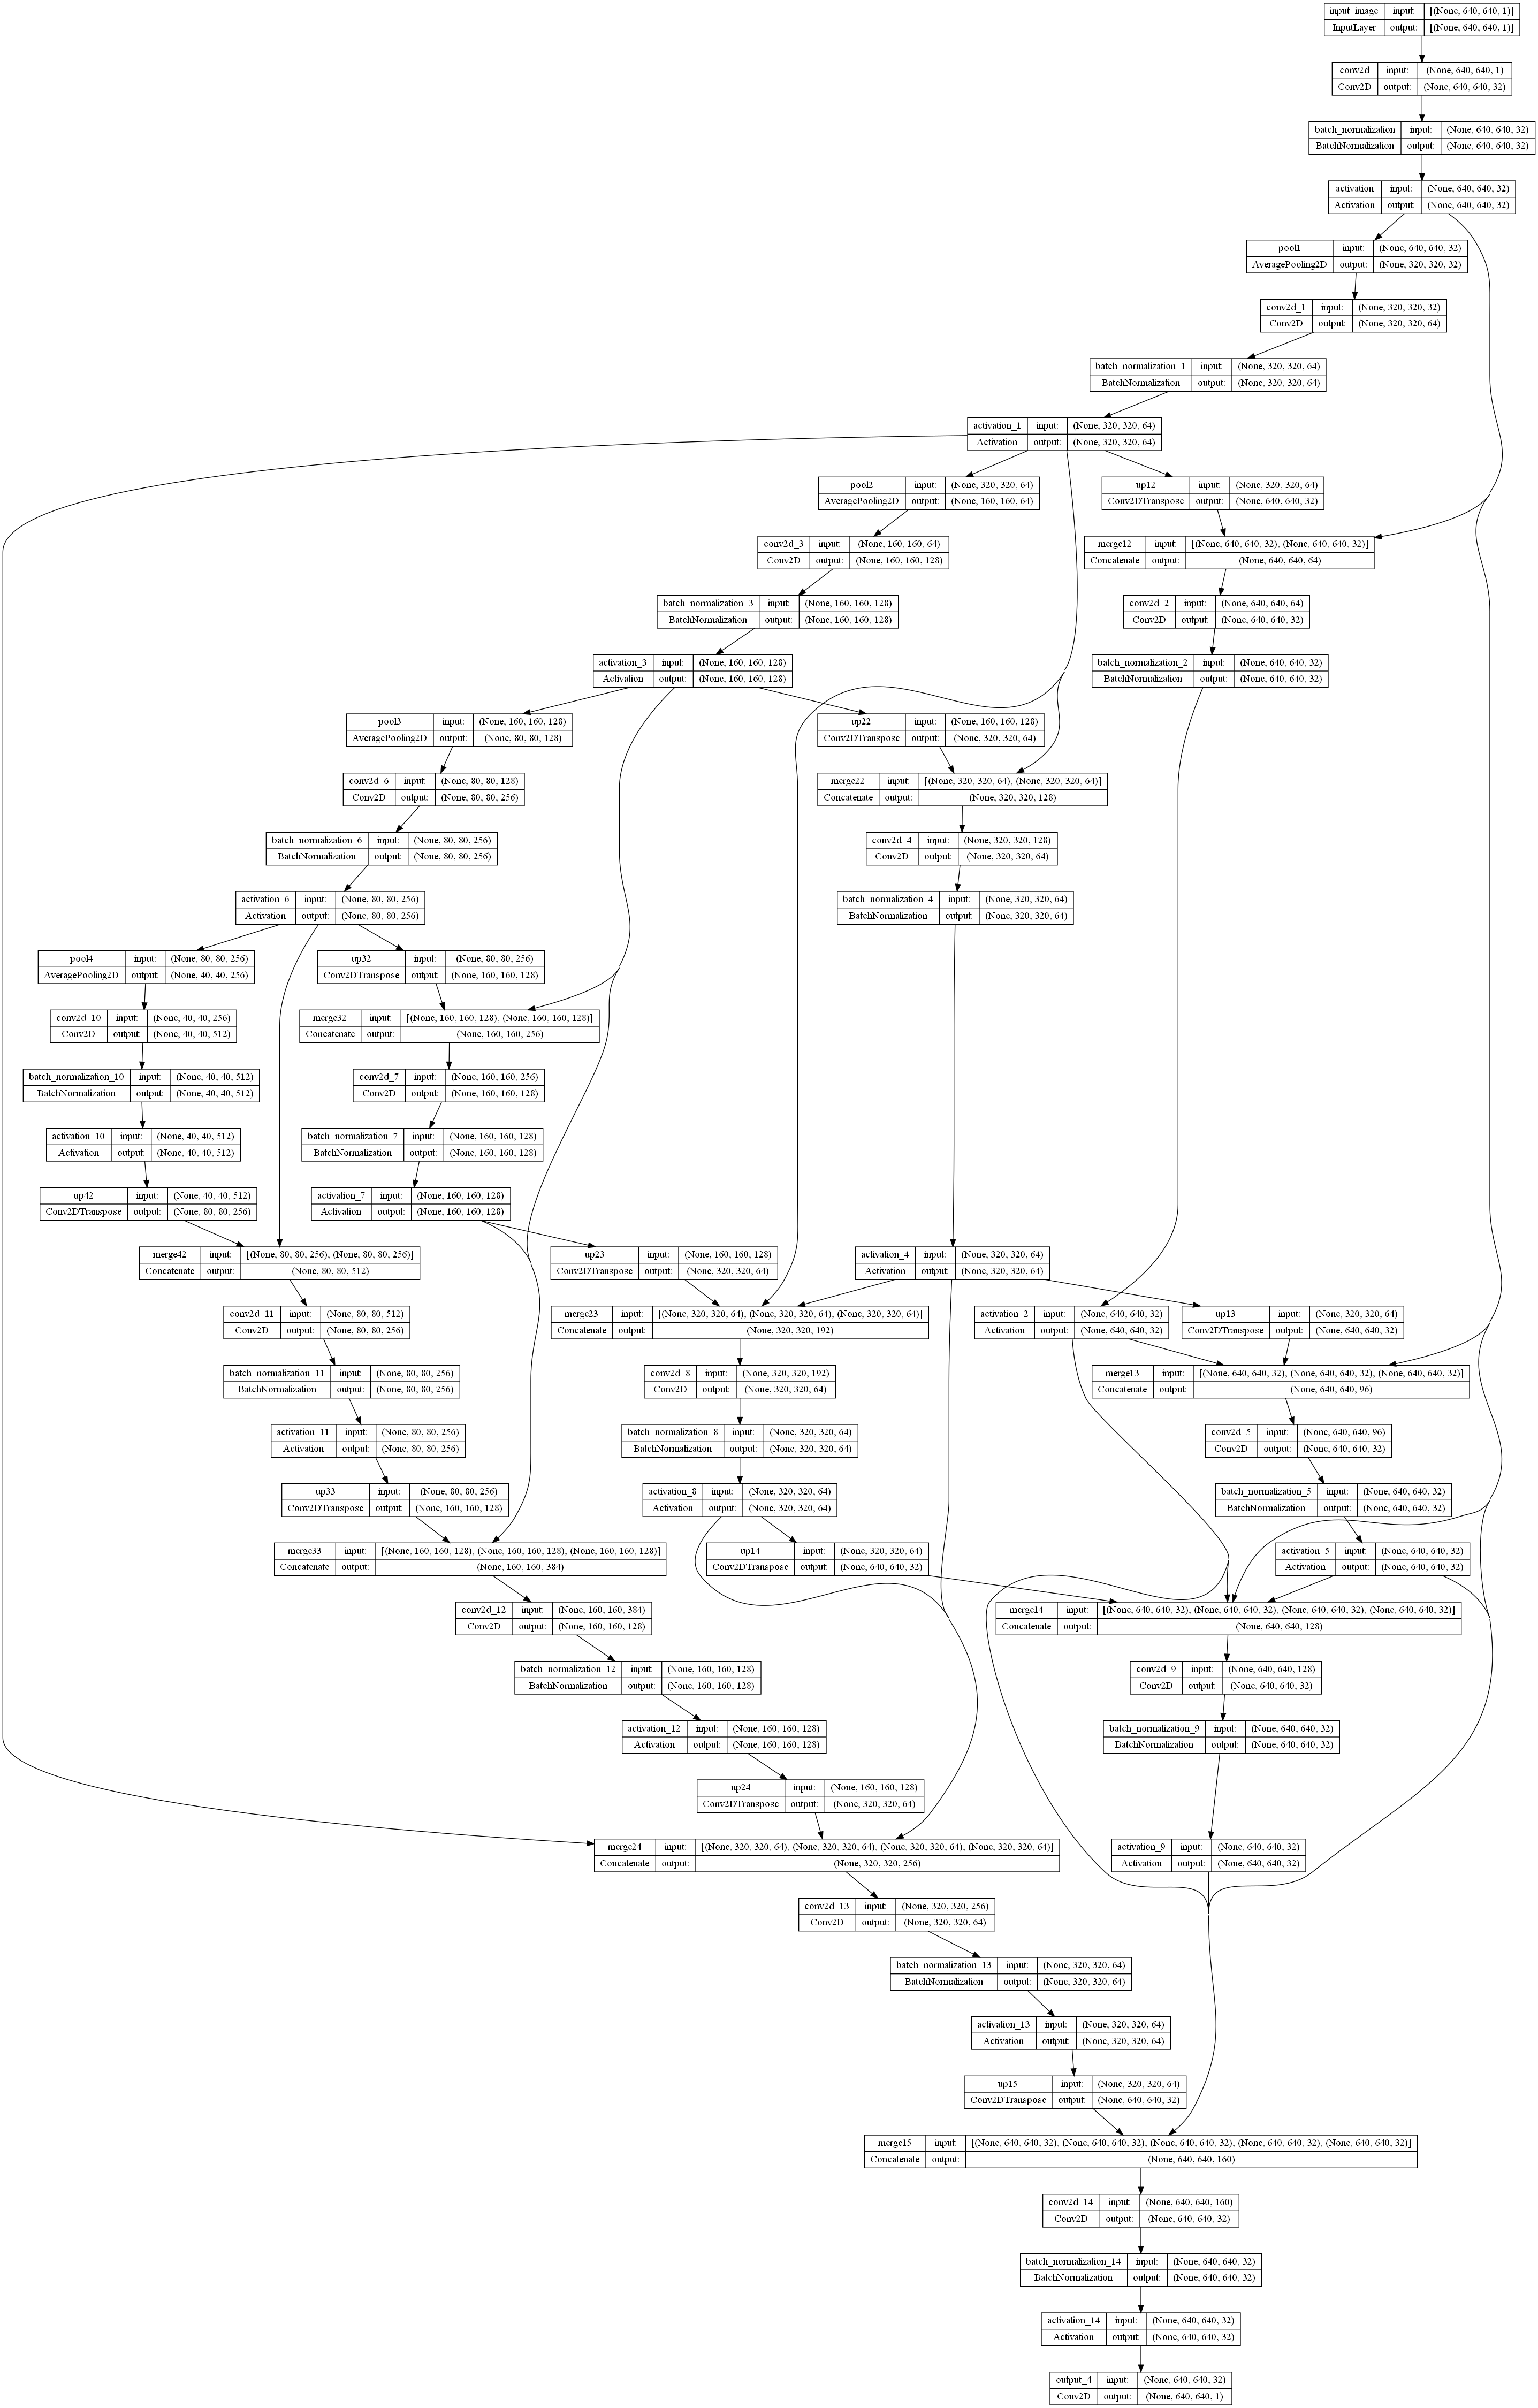

In [30]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

* verbose=0：不輸出任何信息。
* verbose=1：輸出一些基本信息，例如進度條等。
* verbose=2：輸出更詳細的信息。
* `TensorBoard` : 開啟 cmd/終端機，執行 tensorboard --logdir=.\logs，啟動網頁伺服器，再使用瀏覽器輸入以下網址，即可觀看訓練資訊：
http://localhost:6006/
* Keras Callback 的使用 : https://ithelp.ithome.com.tw/articles/10234641?sc=pt

In [31]:

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-UnetPP.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnetPP.csv"),
    TensorBoard(log_dir='./logs')
]

In [32]:
# 載入最近的檢查點的權重
model.load_weights('model-UnetPP.h5') # change 
results = model.fit(X_train, y_train, batch_size=1, epochs=3, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/3


2/2 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.7936 - auc: 0.5738 - sensitivity_at_specificity: 0.5644 - specificity_at_sensitivity: 0.5495 
Epoch 1: val_loss improved from inf to 0.56771, saving model to model-UnetPP.h5
2/2 [==============================] - 39s 14s/step - loss: 0.4938 - accuracy: 0.7936 - auc: 0.5738 - sensitivity_at_specificity: 0.5644 - specificity_at_sensitivity: 0.5495 - val_loss: 0.5677 - val_accuracy: 0.7706 - val_auc: 0.6858 - val_sensitivity_at_specificity: 0.7351 - val_specificity_at_sensitivity: 0.7635 - lr: 0.0010
Epoch 2/3
2/2 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.7947 - auc: 0.6313 - sensitivity_at_specificity: 0.6666 - specificity_at_sensitivity: 0.6666
Epoch 2: val_loss improved from 0.56771 to 0.51843, saving model to model-UnetPP.h5
2/2 [==============================] - 17s 9s/step - loss: 0.4754 - accuracy: 0.7947 - auc: 0.6313 - sensitivity_at_specificity: 0.6666 - specific

In [33]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
2,0.475937,0.794839,0.663433,0.716882,0.700099,0.513874,0.770642,0.610821,0.578317,0.610629,0.001
1,0.475393,0.794663,0.631327,0.666641,0.666591,0.518428,0.770642,0.634384,0.666848,0.646050,0.001
0,0.493837,0.793588,0.573822,0.564414,0.549472,0.567705,0.770642,0.685835,0.735058,0.763451,0.001


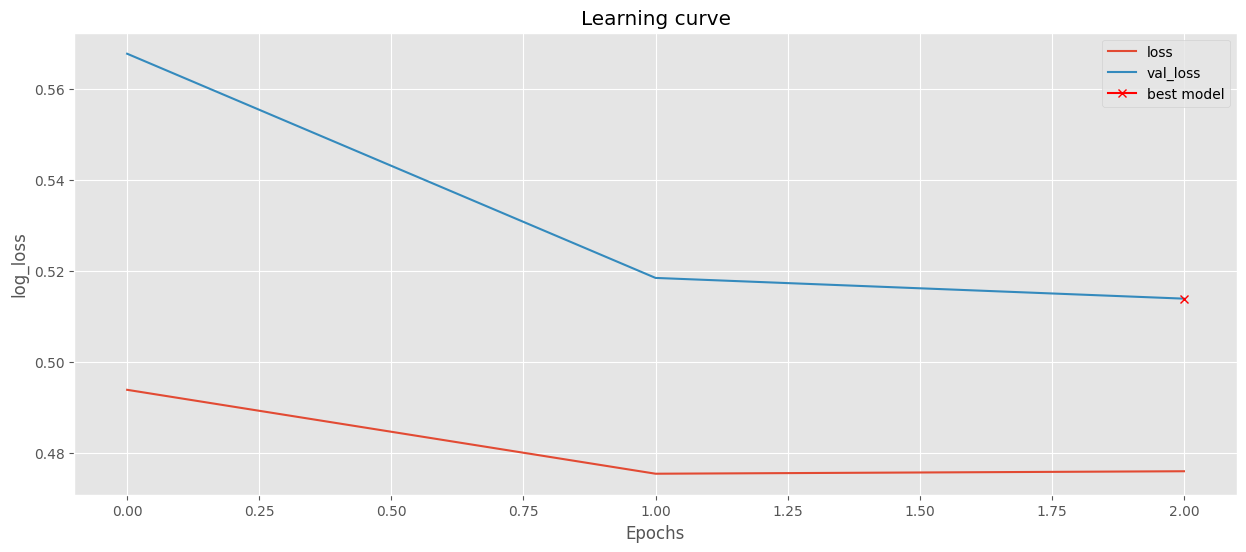

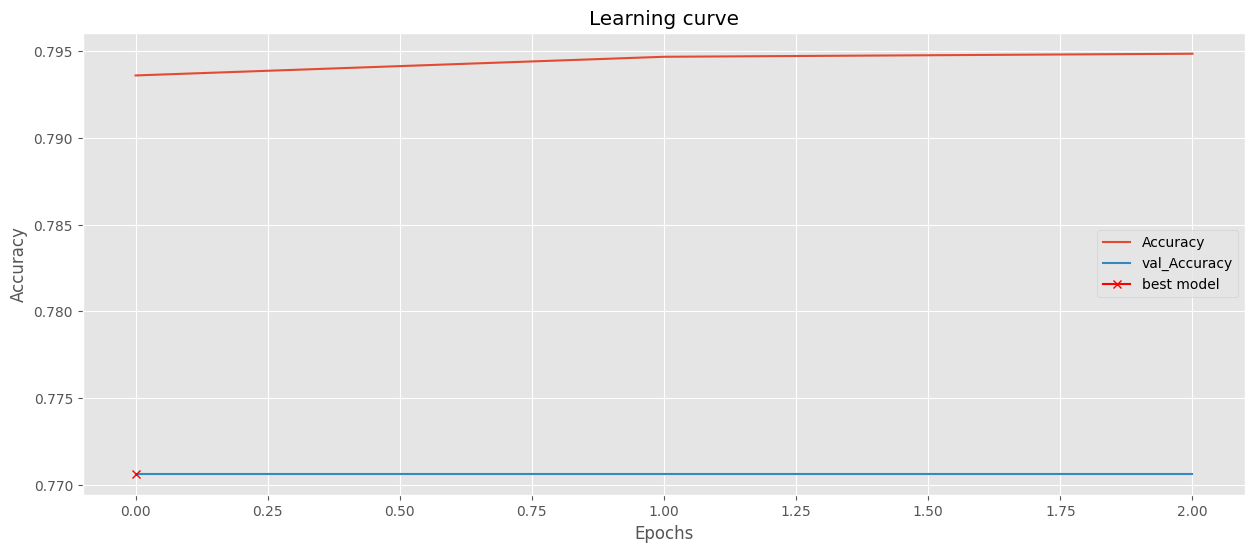

In [34]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [35]:
model.load_weights('model-UnetPP.h5')

In [36]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.5139 - accuracy: 0.7706 - auc: 0.6108 - sensitivity_at_specificity: 0.5783 - specificity_at_sensitivity: 0.6106


[0.5138735175132751,
 0.770642101764679,
 0.6108214855194092,
 0.5783171057701111,
 0.6106286644935608]

In [37]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 1s 928ms/step


In [38]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [39]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Teeth Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Teeth Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Teeth Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Teeth Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

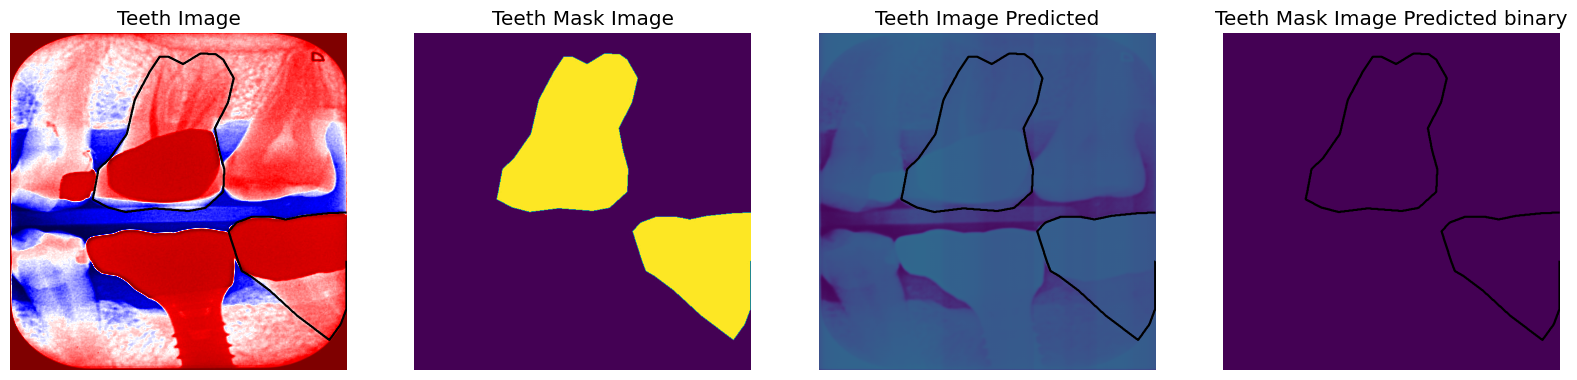

In [43]:
# Check if training data looks all right
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=0)

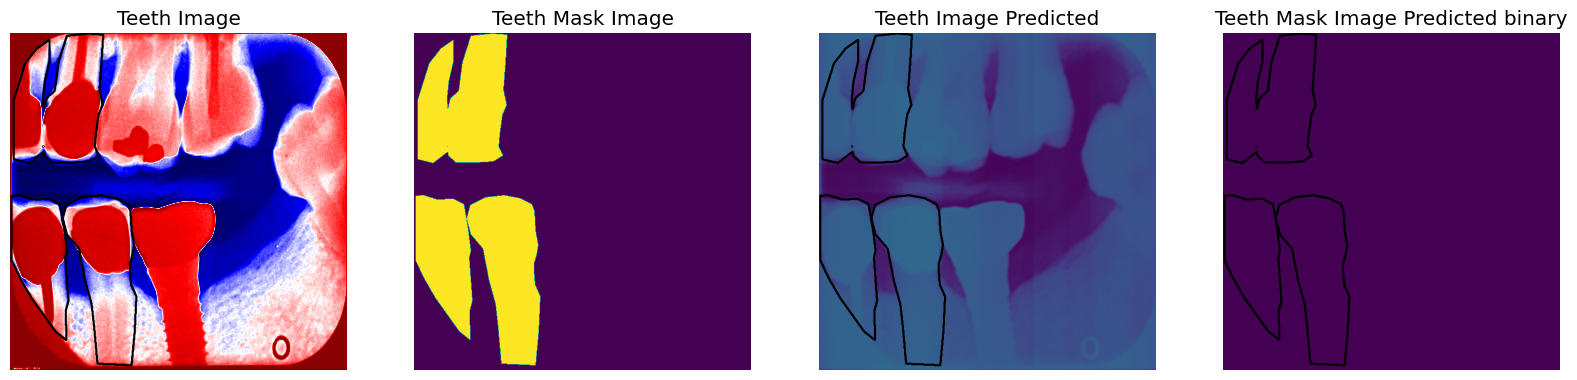

In [41]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

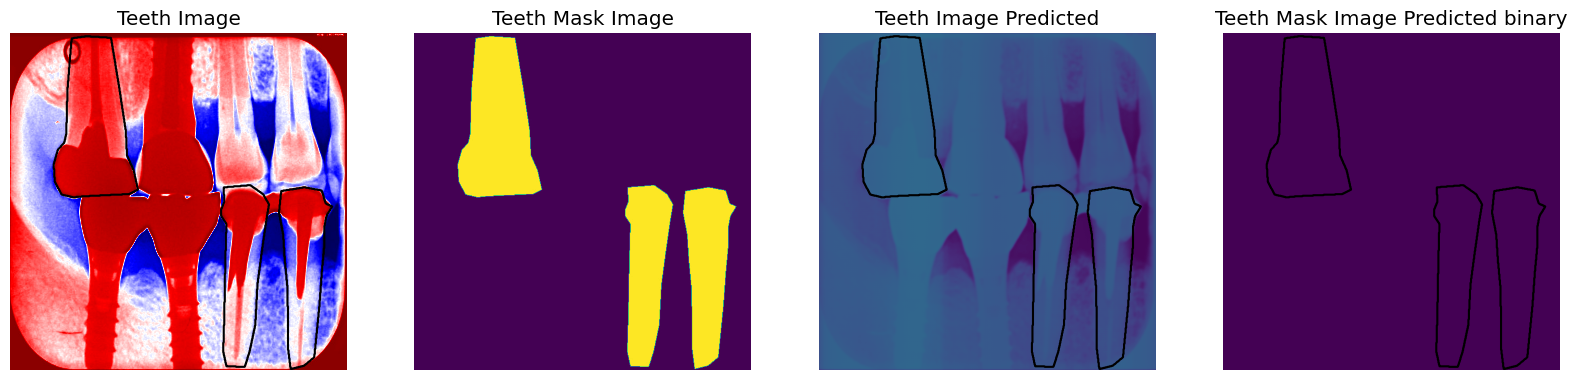

In [42]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

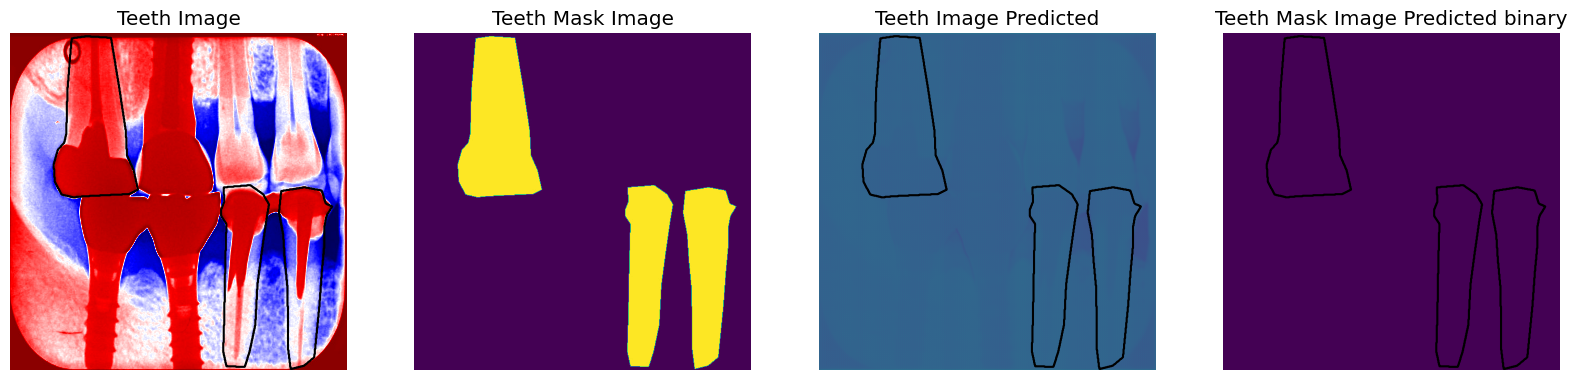

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

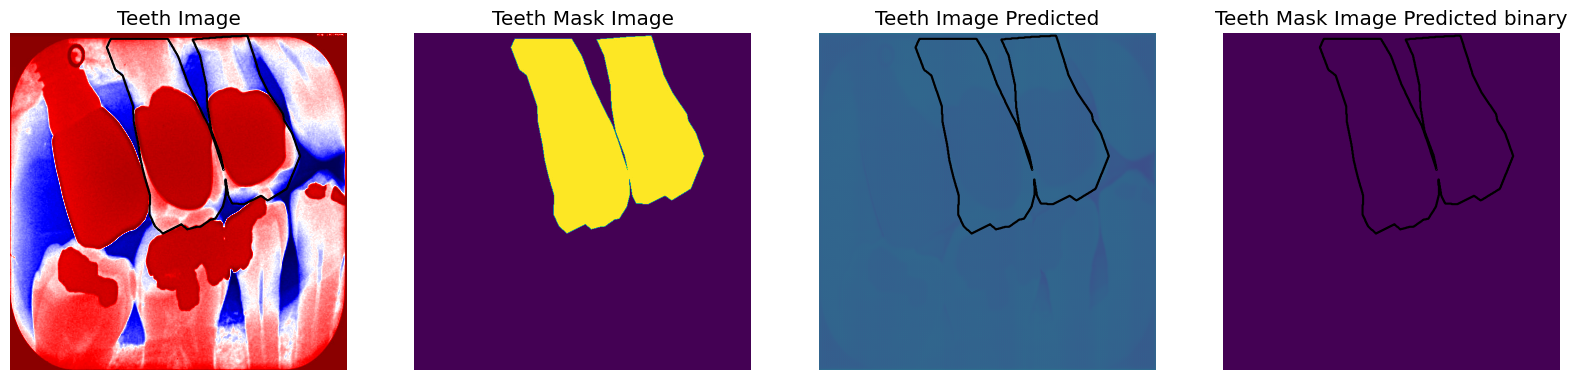

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)